In [14]:
import torch
from torch.autograd import Variable
from torch.nn.parameter import Parameter
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.nn.init as init

%matplotlib inline
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

In [15]:
num_classes = 5
n_features = 6 

In [16]:
from numpy import loadtxt

x_test = loadtxt('problem/X_test_classification.csv',delimiter=',')
targets_test = loadtxt('problem/y_test_classification.csv',delimiter=',')
x_valid = loadtxt('problem/X_val_classification.csv',delimiter=',')
targets_valid = loadtxt('problem/y_val_classification.csv',delimiter=',')
x_train = loadtxt('problem/X_train_classification.csv',delimiter=',')
targets_train = loadtxt('problem/y_train_classification.csv',delimiter=',')

In [19]:
# Load functions
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.optim as optim
from torch.nn import Linear, GRU, Conv2d, Dropout, MaxPool2d, BatchNorm1d, Dropout2d, LSTM
from torch.nn.functional import relu, elu, relu6, sigmoid, tanh, softmax

In [20]:
from torch.nn.functional import relu

#Hyperparameters
out1, out2, out3 = 64, 64, 64
num_features = x_train.shape[1]

# define network
class Net(nn.Module):

    def __init__(self, num_features, num_output):
        super(Net, self).__init__()  
        
        self.l1 = Linear(in_features = num_features,
                            out_features = out1)
        
        self.l2 = Linear(in_features = out1,
                            out_features = out2)
        
        self.l3 = Linear(in_features = out2,
                            out_features = out3)
        
        self.l4 = Linear(in_features = out3,
                            out_features = num_classes)
        
        
        self.dropout = Dropout(p=0.1)
        
        self.bnorm1 = nn.BatchNorm1d(out1)
        self.bnorm2 = nn.BatchNorm1d(out2)
        self.bnorm3 = nn.BatchNorm1d(out3)
        self.bnorm4 = nn.BatchNorm1d(num_classes)
     
    def get_n_params(self):
        pp=0
        for p in list(self.parameters()):
            nn=1
            for s in list(p.size()):
                nn = nn*s
            pp += nn
        return pp

    
    def forward(self, x):        
        x = self.dropout(relu(self.bnorm1(self.l1(x) )))
        x = self.dropout(relu(self.bnorm2(self.l2(x) )))
        x = self.dropout(relu(self.bnorm3(self.l3(x) )))
        x = self.dropout(relu(self.bnorm4(self.l4(x) )))
        
        return x


net = Net(num_features, num_classes)

In [21]:
net.get_n_params()

9487

In [22]:
optimizer = optim.Adam(net.parameters())
criterion = nn.CrossEntropyLoss()

# Build the training loop

Epoch  1 : Train Loss 1.164362 , Train acc 0.897047, Valid acc 0.889231
Epoch  2 : Train Loss 0.935743 , Train acc 0.898121, Valid acc 0.888462
Epoch  3 : Train Loss 0.871264 , Train acc 0.898456, Valid acc 0.886154
Epoch  4 : Train Loss 0.811247 , Train acc 0.897517, Valid acc 0.887308
Epoch  5 : Train Loss 0.797983 , Train acc 0.897852, Valid acc 0.886923
Epoch  6 : Train Loss 0.777743 , Train acc 0.899463, Valid acc 0.886538
Epoch  7 : Train Loss 0.765236 , Train acc 0.900000, Valid acc 0.886154
Epoch  8 : Train Loss 0.765864 , Train acc 0.899128, Valid acc 0.885000
Epoch  9 : Train Loss 0.751093 , Train acc 0.898054, Valid acc 0.883462
Epoch 10 : Train Loss 0.740255 , Train acc 0.899530, Valid acc 0.886154


(Text(0.5, 0, 'Updates'), Text(0, 0.5, 'Acc'))

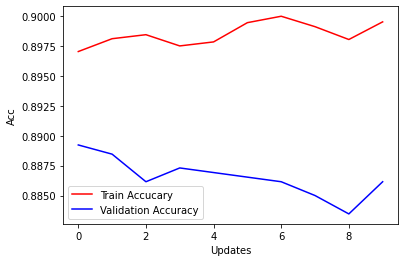

In [23]:
# we could have done this ourselves,
# but we should be aware of sklearn and it's tools
from sklearn.metrics import accuracy_score

# setting hyperparameters and gettings epoch sizes
batch_size = 100
num_epochs = 10
num_samples_train = x_train.shape[0]
num_batches_train = num_samples_train // batch_size
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size

# setting up lists for handling loss/accuracy
train_acc, train_loss = [], []
valid_acc, valid_loss = [], []
test_acc, test_loss = [], []
cur_loss = 0
losses = []

get_slice = lambda i, size: range(i * size, (i + 1) * size)

for epoch in range(num_epochs):
    # Forward -> Backprob -> Update params
    ## Train
    cur_loss = 0
    net.train()
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        output = net(x_batch.float())
        
        # compute gradients given loss
        target_batch = Variable(torch.from_numpy(targets_train[slce]).long())
        batch_loss = criterion(output, target_batch)
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        cur_loss += batch_loss   
    losses.append(cur_loss / batch_size)

    net.eval()
    ### Evaluate training
    train_preds, train_targs = [], []
    for i in range(num_batches_train):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_train[slce]))
        
        output = net(x_batch.float())
        preds = torch.max(output, 1)[1]
        
        train_targs += list(targets_train[slce])
        train_preds += list(preds.data.numpy())
    
    ### Evaluate validation
    val_preds, val_targs = [], []
    for i in range(num_batches_valid):
        slce = get_slice(i, batch_size)
        x_batch = Variable(torch.from_numpy(x_valid[slce]))
        
        output = net(x_batch.float())
        preds = torch.max(output, 1)[1]
        val_preds += list(preds.data.numpy())
        val_targs += list(targets_valid[slce])

    train_acc_cur = accuracy_score(train_targs, train_preds)
    valid_acc_cur = accuracy_score(val_targs, val_preds)
    
    train_acc.append(train_acc_cur)
    valid_acc.append(valid_acc_cur)
    
    if epoch % 1 == 0:
        print("Epoch %2i : Train Loss %f , Train acc %f, Valid acc %f" % (
                epoch+1, losses[-1], train_acc_cur, valid_acc_cur))

epoch = np.arange(len(train_acc))
plt.figure()
plt.plot(epoch, train_acc, 'r', epoch, valid_acc, 'b')
plt.legend(['Train Accucary','Validation Accuracy'])
plt.xlabel('Updates'), plt.ylabel('Acc')

In [24]:
x_valid = np.concatenate((x_valid, x_test), 0)
targets_valid = np.concatenate((targets_valid, targets_test), 0)

In [29]:
num_samples_valid = x_valid.shape[0]
num_batches_valid = num_samples_valid // batch_size 

### Evaluate validation
val_preds, val_targs = [], []
for i in range(1):
    slce = get_slice(i, batch_size)
    x_batch = Variable(torch.from_numpy(x_valid))

    output = net(x_batch.float())
    preds = torch.max(output, 1)[1]
    val_preds += list(preds.data.numpy())
    val_targs += list(targets_valid)

valid_acc_cur = accuracy_score(val_targs, val_preds)
valid_acc_cur

0.8851256983240223

In [32]:
np.savetxt('val_preds_FFN.csv', val_preds, delimiter=',')